# ML4Phys 2023 Assignment 3
## Guoyuan Liu

Acknowledgements:

Code is written with the help of github copilot. `train` and `test` methods are adapted from the solutions to previous exercises.

In [151]:
import h5py
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


device = "cuda" if torch.cuda.is_available() else "cpu"
print("GPU available: ", torch.cuda.is_available())


GPU available:  False


In [2]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)

        y = self.target[index]
        if self.target_transform:
            y = self.target_transform(y)

        return x, y

## Question 1: Data loading and pre-processing

In [3]:
## download and read the .h5 data file
!wget http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
f = h5py.File('Galaxy10.h5')
list(f.keys())

--2024-01-03 23:35:26--  http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5 [following]
--2024-01-03 23:35:26--  https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M)
Saving to: ‘Galaxy10.h5.1’

Galaxy10.h5.1       100%[===================>] 200.50M  18.7MB/s    in 9.3s    

2024-01-03 23:35:36 (21.6 MB/s) - ‘Galaxy10.h5.1’ saved [210234548/210234548]



['ans', 'images']

In [4]:
f["images"]

<HDF5 dataset "images": shape (21785, 69, 69, 3), type "|u1">

In [5]:
# First create np.arrays from the data in the file, then make torch.Tensors from those.
# Directly going to torch.Tensor would be very slow in this case because h5py provides lazy access to the data, (see https://github.com/pytorch/pytorch/issues/13918).

# create numpy arrays for labels and data

data = torch.tensor(np.array(f["images"]))
labels = torch.tensor(np.array(f["ans"]))

# we change the data type and permute the color channel axis from place 3 to 1, to conform with pytorch defaults.
data = data.type(torch.float32).permute(0,3,1,2)  # leave this as is
labels = labels.type(torch.LongTensor)            # leave this as is

In [6]:
# seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [23]:
# continue with computing the channel means and std's after cropping on a subset of the data

# random cropped samples
crop = transforms.RandomCrop((48,48))
samples = data[np.random.choice(len(data), 1000, replace=False), :, :, :]
cropped_samples = crop(samples)

# compute the channel means and std's on samples
normalize = transforms.Normalize(cropped_samples.mean(axis=(0,2,3)), cropped_samples.std(axis=(0,2,3)))



In [24]:
# define the composed transform

transform = transforms.Compose([crop, normalize])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [46]:
# create train and test datasets for the two tasks as instances of the MyDataset class, e.g.
# example_dataset = MyDataset(example_data, example_labels, transform=example_transform)
main_idx = torch.where(labels <=7)[0]
main = MyDataset(data[main_idx], labels[main_idx], transform=transform)
held_out_idx = torch.where(labels >= 8)[0]
held_out = MyDataset(data[held_out_idx], labels[held_out_idx] - 8, transform=transform)

# then create data loaders with batch size 64
train_main, test_main = random_split(main, [18000, len(main) - 18000])
train_heldout, test_heldout = random_split(held_out, [1000, len(held_out) - 1000])

train_main_dl = DataLoader(batch_size=64, dataset=train_main, shuffle=True)
train_heldout_dl = DataLoader(batch_size=64, dataset=train_heldout, shuffle=True)

test_main_dl = DataLoader(batch_size=64, dataset=test_main, shuffle=False)
test_heldout_dl = DataLoader(batch_size=64, dataset=test_heldout, shuffle=False)


## Question 2: Fully connected network

In [68]:
# define and train the FCN

class FCN(nn.Module):
    def __init__(self, device):
        super(FCN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*48*48, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        ).to(device)

    def forward(self, x):
        return self.model(x)
        
# Hint: Define train() and test() functions which you can reuse for the other models in the later questions
#       (as done in the exercise sessions).

def train(dataloader, model, loss_fn, optimizer):
    '''
    This function implements the train loop. It iterates over the training dataset
    and try to converge to optimal parameters.
    '''
    model.train() # Set the model to training mode
    train_loss = 0
    num_batches = len(dataloader)
    with tqdm(total=num_batches) as pbar:
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction and loss
            pred = model(X) # Pass the data to the model to execute the model forward
            loss = loss_fn(pred, y)
            train_loss += loss.item()

            # Backpropagation
            loss.backward() # Compute gradients of the loss w.r.t parameters (backward pass)
            optimizer.step() # Do a gradient descent step and adjust parameters
            optimizer.zero_grad() # Reset the gradients of model parameters to zero (gradients by default add up)
            pbar.set_description(f"train loss {loss:>.7f}")
            pbar.update(1)
    return train_loss / len(dataloader)
    

def test(dataloader, model, loss_fn):
    '''
    This function implements the validation/test loop. It iterates over the test
    dataset to check if the model performance is improving.
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Set the model to evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad(): # Do not track gradients while evaluating (faster)
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # Compute CE loss on the batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # Compute classification error
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct
    

In [70]:
fcn = FCN(device)

train_losses = []
test_losses = []
for epoch in range(50):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_losses.append(train(train_main_dl, fcn, nn.CrossEntropyLoss(), torch.optim.Adam(fcn.parameters(), lr=1e-3)))
    test_losses.append(test(test_main_dl, fcn, nn.CrossEntropyLoss())[0])

Epoch 1
-------------------------------


train loss 1.3869748: 100%|██████████| 282/282 [00:02<00:00, 101.16it/s]


Test Error: 
 Accuracy: 44.4%, Avg loss: 1.367594 

Epoch 2
-------------------------------


train loss 1.1858490: 100%|██████████| 282/282 [00:02<00:00, 102.94it/s]


Test Error: 
 Accuracy: 45.2%, Avg loss: 1.286155 

Epoch 3
-------------------------------


train loss 1.1147131: 100%|██████████| 282/282 [00:02<00:00, 111.00it/s]


Test Error: 
 Accuracy: 50.6%, Avg loss: 1.215312 

Epoch 4
-------------------------------


train loss 0.8354297: 100%|██████████| 282/282 [00:02<00:00, 103.38it/s]


Test Error: 
 Accuracy: 53.7%, Avg loss: 1.178089 

Epoch 5
-------------------------------


train loss 0.8492268: 100%|██████████| 282/282 [00:02<00:00, 108.00it/s]


Test Error: 
 Accuracy: 54.9%, Avg loss: 1.180832 

Epoch 6
-------------------------------


train loss 1.1409222: 100%|██████████| 282/282 [00:02<00:00, 97.52it/s] 


Test Error: 
 Accuracy: 56.4%, Avg loss: 1.128962 

Epoch 7
-------------------------------


train loss 0.9751909: 100%|██████████| 282/282 [00:02<00:00, 103.14it/s]


Test Error: 
 Accuracy: 56.1%, Avg loss: 1.200046 

Epoch 8
-------------------------------


train loss 0.9205087: 100%|██████████| 282/282 [00:02<00:00, 94.04it/s] 


Test Error: 
 Accuracy: 56.1%, Avg loss: 1.190858 

Epoch 9
-------------------------------


train loss 0.7338142: 100%|██████████| 282/282 [00:02<00:00, 110.74it/s]


Test Error: 
 Accuracy: 57.8%, Avg loss: 1.163300 

Epoch 10
-------------------------------


train loss 1.0582278: 100%|██████████| 282/282 [00:02<00:00, 103.01it/s]


Test Error: 
 Accuracy: 57.7%, Avg loss: 1.246533 

Epoch 11
-------------------------------


train loss 0.8957466: 100%|██████████| 282/282 [00:02<00:00, 94.71it/s] 


Test Error: 
 Accuracy: 59.2%, Avg loss: 1.305055 

Epoch 12
-------------------------------


train loss 0.6629589: 100%|██████████| 282/282 [00:02<00:00, 100.66it/s]


Test Error: 
 Accuracy: 60.0%, Avg loss: 1.179634 

Epoch 13
-------------------------------


train loss 1.7553737: 100%|██████████| 282/282 [00:02<00:00, 108.76it/s]


Test Error: 
 Accuracy: 59.6%, Avg loss: 1.189993 

Epoch 14
-------------------------------


train loss 1.3936886: 100%|██████████| 282/282 [00:02<00:00, 102.17it/s]


Test Error: 
 Accuracy: 60.6%, Avg loss: 1.338726 

Epoch 15
-------------------------------


train loss 1.0821062: 100%|██████████| 282/282 [00:02<00:00, 105.97it/s]


Test Error: 
 Accuracy: 58.7%, Avg loss: 1.230482 

Epoch 16
-------------------------------


train loss 0.9984152: 100%|██████████| 282/282 [00:02<00:00, 97.24it/s] 


Test Error: 
 Accuracy: 60.1%, Avg loss: 1.368632 

Epoch 17
-------------------------------


train loss 0.8627518: 100%|██████████| 282/282 [00:02<00:00, 102.42it/s]


Test Error: 
 Accuracy: 60.8%, Avg loss: 1.154101 

Epoch 18
-------------------------------


train loss 0.6603810: 100%|██████████| 282/282 [00:02<00:00, 100.66it/s]


Test Error: 
 Accuracy: 59.3%, Avg loss: 1.093671 

Epoch 19
-------------------------------


train loss 0.9053705: 100%|██████████| 282/282 [00:02<00:00, 106.03it/s]


Test Error: 
 Accuracy: 61.4%, Avg loss: 1.192753 

Epoch 20
-------------------------------


train loss 0.5942043: 100%|██████████| 282/282 [00:02<00:00, 104.44it/s]


Test Error: 
 Accuracy: 63.0%, Avg loss: 1.088037 

Epoch 21
-------------------------------


train loss 0.8087031: 100%|██████████| 282/282 [00:02<00:00, 109.91it/s]


Test Error: 
 Accuracy: 62.1%, Avg loss: 1.106397 

Epoch 22
-------------------------------


train loss 0.4985483: 100%|██████████| 282/282 [00:02<00:00, 111.63it/s]


Test Error: 
 Accuracy: 60.0%, Avg loss: 1.120106 

Epoch 23
-------------------------------


train loss 0.8803424: 100%|██████████| 282/282 [00:02<00:00, 113.34it/s]


Test Error: 
 Accuracy: 59.2%, Avg loss: 1.100593 

Epoch 24
-------------------------------


train loss 0.6221576: 100%|██████████| 282/282 [00:02<00:00, 95.63it/s] 


Test Error: 
 Accuracy: 61.1%, Avg loss: 1.133287 

Epoch 25
-------------------------------


train loss 0.8211491: 100%|██████████| 282/282 [00:02<00:00, 99.59it/s] 


Test Error: 
 Accuracy: 62.1%, Avg loss: 1.439098 

Epoch 26
-------------------------------


train loss 1.1695992: 100%|██████████| 282/282 [00:03<00:00, 92.29it/s] 


Test Error: 
 Accuracy: 61.9%, Avg loss: 1.098852 

Epoch 27
-------------------------------


train loss 0.9998217: 100%|██████████| 282/282 [00:02<00:00, 102.02it/s]


Test Error: 
 Accuracy: 63.6%, Avg loss: 1.101723 

Epoch 28
-------------------------------


train loss 0.6935511: 100%|██████████| 282/282 [00:02<00:00, 99.69it/s] 


Test Error: 
 Accuracy: 60.9%, Avg loss: 1.333930 

Epoch 29
-------------------------------


train loss 1.1817721: 100%|██████████| 282/282 [00:02<00:00, 105.13it/s]


Test Error: 
 Accuracy: 59.7%, Avg loss: 1.470730 

Epoch 30
-------------------------------


train loss 0.7667670: 100%|██████████| 282/282 [00:02<00:00, 94.56it/s] 


Test Error: 
 Accuracy: 61.6%, Avg loss: 1.171273 

Epoch 31
-------------------------------


train loss 0.7777700: 100%|██████████| 282/282 [00:02<00:00, 95.70it/s] 


Test Error: 
 Accuracy: 61.1%, Avg loss: 1.110294 

Epoch 32
-------------------------------


train loss 1.1939683: 100%|██████████| 282/282 [00:02<00:00, 95.21it/s] 


Test Error: 
 Accuracy: 61.9%, Avg loss: 1.153004 

Epoch 33
-------------------------------


train loss 0.9442428: 100%|██████████| 282/282 [00:02<00:00, 99.05it/s] 


Test Error: 
 Accuracy: 60.0%, Avg loss: 1.252068 

Epoch 34
-------------------------------


train loss 0.8579345: 100%|██████████| 282/282 [00:02<00:00, 109.98it/s]


Test Error: 
 Accuracy: 61.3%, Avg loss: 1.432142 

Epoch 35
-------------------------------


train loss 1.3008734: 100%|██████████| 282/282 [00:02<00:00, 104.74it/s]


Test Error: 
 Accuracy: 60.0%, Avg loss: 1.257876 

Epoch 36
-------------------------------


train loss 0.8711736: 100%|██████████| 282/282 [00:02<00:00, 101.86it/s]


Test Error: 
 Accuracy: 60.6%, Avg loss: 1.497320 

Epoch 37
-------------------------------


train loss 0.7706289: 100%|██████████| 282/282 [00:02<00:00, 100.76it/s]


Test Error: 
 Accuracy: 62.3%, Avg loss: 1.314272 

Epoch 38
-------------------------------


train loss 0.4720265: 100%|██████████| 282/282 [00:02<00:00, 103.54it/s]


Test Error: 
 Accuracy: 62.7%, Avg loss: 1.645816 

Epoch 39
-------------------------------


train loss 0.9429590: 100%|██████████| 282/282 [00:02<00:00, 97.38it/s] 


Test Error: 
 Accuracy: 61.5%, Avg loss: 1.172534 

Epoch 40
-------------------------------


train loss 0.7637231: 100%|██████████| 282/282 [00:02<00:00, 99.08it/s] 


Test Error: 
 Accuracy: 63.7%, Avg loss: 1.256988 

Epoch 41
-------------------------------


train loss 0.5691899: 100%|██████████| 282/282 [00:02<00:00, 106.19it/s]


Test Error: 
 Accuracy: 62.3%, Avg loss: 1.332507 

Epoch 42
-------------------------------


train loss 0.6714301: 100%|██████████| 282/282 [00:03<00:00, 90.96it/s]


Test Error: 
 Accuracy: 61.2%, Avg loss: 1.125781 

Epoch 43
-------------------------------


train loss 0.8618902: 100%|██████████| 282/282 [00:02<00:00, 104.59it/s]


Test Error: 
 Accuracy: 60.6%, Avg loss: 1.144146 

Epoch 44
-------------------------------


train loss 0.9481245: 100%|██████████| 282/282 [00:02<00:00, 113.73it/s]


Test Error: 
 Accuracy: 61.4%, Avg loss: 1.186807 

Epoch 45
-------------------------------


train loss 0.5926726: 100%|██████████| 282/282 [00:02<00:00, 110.46it/s]


Test Error: 
 Accuracy: 60.9%, Avg loss: 1.254397 

Epoch 46
-------------------------------


train loss 0.9006328: 100%|██████████| 282/282 [00:02<00:00, 102.93it/s]


Test Error: 
 Accuracy: 58.9%, Avg loss: 1.228312 

Epoch 47
-------------------------------


train loss 0.6997281: 100%|██████████| 282/282 [00:02<00:00, 103.47it/s]


Test Error: 
 Accuracy: 59.5%, Avg loss: 1.313883 

Epoch 48
-------------------------------


train loss 0.7026445: 100%|██████████| 282/282 [00:02<00:00, 97.91it/s] 


Test Error: 
 Accuracy: 60.4%, Avg loss: 1.235329 

Epoch 49
-------------------------------


train loss 0.8999022: 100%|██████████| 282/282 [00:02<00:00, 105.94it/s]


Test Error: 
 Accuracy: 62.0%, Avg loss: 1.260927 

Epoch 50
-------------------------------


train loss 0.5339406: 100%|██████████| 282/282 [00:02<00:00, 104.07it/s]


Test Error: 
 Accuracy: 61.1%, Avg loss: 1.693182 



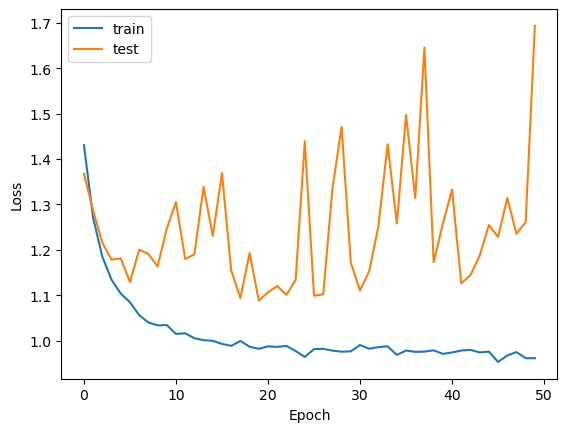

In [71]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Train loss decreases steadily with more training epochs, while the test loss oscillates after the decline of the first few ecochs. The trend suggests that the model stopped to learn the generalizable relations of the data after relatively small amount of training and begin to overfit.

## Question 3: Convolutional network

In [77]:
# Define and train the CNN
class CNN(nn.Module):
    def __init__(self, device):
        super(CNN, self).__init__()
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 8, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(1296, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        ).to(device)
        self.classifier = nn.Linear(64, 8).to(device)

    def forward(self, x):
        x = self.cnn_backbone(x)
        return self.classifier(x)

cnn = CNN(device)

train_losses_cnn = []
test_losses_cnn = []
for epoch in range(50):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_losses_cnn.append(train(train_main_dl, cnn, nn.CrossEntropyLoss(), torch.optim.Adam(cnn.parameters(), lr=2e-3)))
    test_losses_cnn.append(test(test_main_dl, cnn, nn.CrossEntropyLoss())[0])



Epoch 1
-------------------------------


train loss 2.0477951:   0%|          | 0/282 [00:00<?, ?it/s]

train loss 1.4225285: 100%|██████████| 282/282 [00:04<00:00, 68.35it/s]


Test Error: 
 Accuracy: 47.1%, Avg loss: 1.286334 

Epoch 2
-------------------------------


train loss 1.2874442: 100%|██████████| 282/282 [00:04<00:00, 69.67it/s]


Test Error: 
 Accuracy: 51.2%, Avg loss: 1.089160 

Epoch 3
-------------------------------


train loss 0.9254472: 100%|██████████| 282/282 [00:03<00:00, 72.87it/s]


Test Error: 
 Accuracy: 51.6%, Avg loss: 1.098477 

Epoch 4
-------------------------------


train loss 0.9402705: 100%|██████████| 282/282 [00:03<00:00, 72.55it/s]


Test Error: 
 Accuracy: 60.0%, Avg loss: 0.979463 

Epoch 5
-------------------------------


train loss 1.2151326: 100%|██████████| 282/282 [00:03<00:00, 73.54it/s]


Test Error: 
 Accuracy: 61.9%, Avg loss: 0.920717 

Epoch 6
-------------------------------


train loss 0.6880552: 100%|██████████| 282/282 [00:04<00:00, 66.82it/s]


Test Error: 
 Accuracy: 64.4%, Avg loss: 0.878521 

Epoch 7
-------------------------------


train loss 1.0712570: 100%|██████████| 282/282 [00:03<00:00, 74.14it/s]


Test Error: 
 Accuracy: 68.5%, Avg loss: 0.850673 

Epoch 8
-------------------------------


train loss 1.0210444: 100%|██████████| 282/282 [00:04<00:00, 67.95it/s]


Test Error: 
 Accuracy: 69.2%, Avg loss: 0.785016 

Epoch 9
-------------------------------


train loss 0.7587243: 100%|██████████| 282/282 [00:03<00:00, 72.29it/s]


Test Error: 
 Accuracy: 70.0%, Avg loss: 0.829868 

Epoch 10
-------------------------------


train loss 0.3822310: 100%|██████████| 282/282 [00:04<00:00, 69.29it/s]


Test Error: 
 Accuracy: 71.5%, Avg loss: 0.775010 

Epoch 11
-------------------------------


train loss 0.6520441: 100%|██████████| 282/282 [00:04<00:00, 68.15it/s]


Test Error: 
 Accuracy: 72.5%, Avg loss: 0.730859 

Epoch 12
-------------------------------


train loss 0.5459883: 100%|██████████| 282/282 [00:04<00:00, 67.16it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.656554 

Epoch 13
-------------------------------


train loss 0.5914451: 100%|██████████| 282/282 [00:04<00:00, 64.36it/s]


Test Error: 
 Accuracy: 73.9%, Avg loss: 0.695390 

Epoch 14
-------------------------------


train loss 0.4830694: 100%|██████████| 282/282 [00:04<00:00, 69.79it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.672103 

Epoch 15
-------------------------------


train loss 0.3943196: 100%|██████████| 282/282 [00:04<00:00, 64.87it/s]


Test Error: 
 Accuracy: 72.5%, Avg loss: 0.710451 

Epoch 16
-------------------------------


train loss 0.7606599: 100%|██████████| 282/282 [00:03<00:00, 70.82it/s]


Test Error: 
 Accuracy: 75.5%, Avg loss: 0.654982 

Epoch 17
-------------------------------


train loss 0.2848463: 100%|██████████| 282/282 [00:04<00:00, 70.29it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.640703 

Epoch 18
-------------------------------


train loss 0.2354150: 100%|██████████| 282/282 [00:03<00:00, 71.50it/s]


Test Error: 
 Accuracy: 76.1%, Avg loss: 0.638993 

Epoch 19
-------------------------------


train loss 0.2934024: 100%|██████████| 282/282 [00:04<00:00, 67.70it/s]


Test Error: 
 Accuracy: 76.7%, Avg loss: 0.668165 

Epoch 20
-------------------------------


train loss 1.0880072: 100%|██████████| 282/282 [00:04<00:00, 68.95it/s]


Test Error: 
 Accuracy: 77.5%, Avg loss: 0.600362 

Epoch 21
-------------------------------


train loss 0.2964232: 100%|██████████| 282/282 [00:03<00:00, 70.67it/s]


Test Error: 
 Accuracy: 78.7%, Avg loss: 0.610169 

Epoch 22
-------------------------------


train loss 0.6731347: 100%|██████████| 282/282 [00:04<00:00, 66.36it/s]


Test Error: 
 Accuracy: 73.3%, Avg loss: 0.707937 

Epoch 23
-------------------------------


train loss 0.4450368: 100%|██████████| 282/282 [00:04<00:00, 67.90it/s]


Test Error: 
 Accuracy: 77.0%, Avg loss: 0.625967 

Epoch 24
-------------------------------


train loss 0.3638687: 100%|██████████| 282/282 [00:03<00:00, 75.98it/s]


Test Error: 
 Accuracy: 78.3%, Avg loss: 0.622046 

Epoch 25
-------------------------------


train loss 0.7598067: 100%|██████████| 282/282 [00:03<00:00, 72.12it/s]


Test Error: 
 Accuracy: 79.2%, Avg loss: 0.606475 

Epoch 26
-------------------------------


train loss 0.9121014: 100%|██████████| 282/282 [00:04<00:00, 68.18it/s]


Test Error: 
 Accuracy: 77.8%, Avg loss: 0.618359 

Epoch 27
-------------------------------


train loss 0.4831659: 100%|██████████| 282/282 [00:04<00:00, 70.26it/s]


Test Error: 
 Accuracy: 71.6%, Avg loss: 0.708790 

Epoch 28
-------------------------------


train loss 0.5589795: 100%|██████████| 282/282 [00:03<00:00, 70.99it/s]


Test Error: 
 Accuracy: 77.0%, Avg loss: 0.650406 

Epoch 29
-------------------------------


train loss 0.4565068: 100%|██████████| 282/282 [00:04<00:00, 64.96it/s]


Test Error: 
 Accuracy: 77.8%, Avg loss: 0.571983 

Epoch 30
-------------------------------


train loss 0.7744147: 100%|██████████| 282/282 [00:04<00:00, 67.74it/s]


Test Error: 
 Accuracy: 76.2%, Avg loss: 0.644096 

Epoch 31
-------------------------------


train loss 0.2167128: 100%|██████████| 282/282 [00:04<00:00, 70.07it/s]


Test Error: 
 Accuracy: 77.3%, Avg loss: 0.616430 

Epoch 32
-------------------------------


train loss 0.3655555: 100%|██████████| 282/282 [00:03<00:00, 72.60it/s]


Test Error: 
 Accuracy: 79.4%, Avg loss: 0.631885 

Epoch 33
-------------------------------


train loss 0.3794312: 100%|██████████| 282/282 [00:04<00:00, 68.87it/s]


Test Error: 
 Accuracy: 77.8%, Avg loss: 0.618408 

Epoch 34
-------------------------------


train loss 0.5929906: 100%|██████████| 282/282 [00:04<00:00, 68.04it/s]


Test Error: 
 Accuracy: 78.1%, Avg loss: 0.633824 

Epoch 35
-------------------------------


train loss 0.4694717: 100%|██████████| 282/282 [00:03<00:00, 70.79it/s]


Test Error: 
 Accuracy: 79.7%, Avg loss: 0.590592 

Epoch 36
-------------------------------


train loss 0.7674374: 100%|██████████| 282/282 [00:04<00:00, 66.05it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.588033 

Epoch 37
-------------------------------


train loss 0.3153316: 100%|██████████| 282/282 [00:04<00:00, 69.90it/s]


Test Error: 
 Accuracy: 79.1%, Avg loss: 0.616133 

Epoch 38
-------------------------------


train loss 0.5289719: 100%|██████████| 282/282 [00:03<00:00, 71.28it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.619422 

Epoch 39
-------------------------------


train loss 0.8639323: 100%|██████████| 282/282 [00:03<00:00, 72.28it/s]


Test Error: 
 Accuracy: 78.9%, Avg loss: 0.603215 

Epoch 40
-------------------------------


train loss 0.8912629: 100%|██████████| 282/282 [00:04<00:00, 69.18it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.618227 

Epoch 41
-------------------------------


train loss 0.4992188: 100%|██████████| 282/282 [00:04<00:00, 67.36it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.666135 

Epoch 42
-------------------------------


train loss 0.6997890: 100%|██████████| 282/282 [00:03<00:00, 74.04it/s]


Test Error: 
 Accuracy: 75.9%, Avg loss: 0.659458 

Epoch 43
-------------------------------


train loss 0.5542195: 100%|██████████| 282/282 [00:03<00:00, 70.95it/s]


Test Error: 
 Accuracy: 80.0%, Avg loss: 0.648387 

Epoch 44
-------------------------------


train loss 0.3692587: 100%|██████████| 282/282 [00:03<00:00, 72.12it/s]


Test Error: 
 Accuracy: 78.4%, Avg loss: 0.618879 

Epoch 45
-------------------------------


train loss 0.7854741: 100%|██████████| 282/282 [00:04<00:00, 70.17it/s]


Test Error: 
 Accuracy: 77.7%, Avg loss: 0.696059 

Epoch 46
-------------------------------


train loss 0.3069268: 100%|██████████| 282/282 [00:04<00:00, 68.22it/s]


Test Error: 
 Accuracy: 80.0%, Avg loss: 0.565822 

Epoch 47
-------------------------------


train loss 0.4907243: 100%|██████████| 282/282 [00:04<00:00, 65.91it/s]


Test Error: 
 Accuracy: 74.7%, Avg loss: 0.720499 

Epoch 48
-------------------------------


train loss 0.4847240: 100%|██████████| 282/282 [00:04<00:00, 69.61it/s]


Test Error: 
 Accuracy: 79.6%, Avg loss: 0.611236 

Epoch 49
-------------------------------


train loss 0.1539450: 100%|██████████| 282/282 [00:03<00:00, 72.15it/s]


Test Error: 
 Accuracy: 80.7%, Avg loss: 0.608155 

Epoch 50
-------------------------------


train loss 0.3650446: 100%|██████████| 282/282 [00:04<00:00, 68.57it/s]


Test Error: 
 Accuracy: 80.0%, Avg loss: 0.589939 



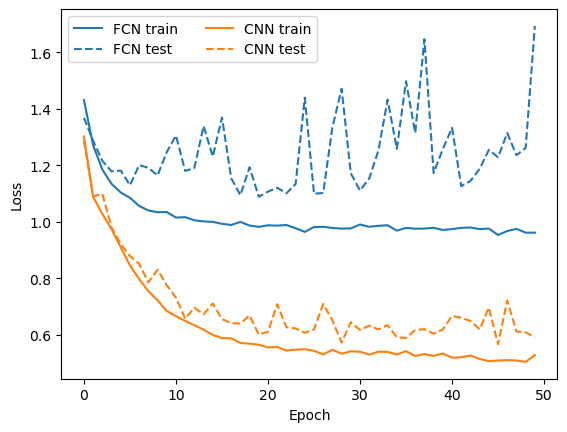

In [86]:
# Compare test accuracies of FCN and CNN

plt.plot(train_losses, color="tab:blue", label="FCN train")
plt.plot(test_losses, '--', color="tab:blue", label="FCN test")
plt.plot(train_losses_cnn, color="tab:orange", label="CNN train")
plt.plot(test_losses_cnn, '--', color="tab:orange", label="CNN test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best", ncol=2)
plt.show()


In [78]:
acc_fcn = test(test_main_dl, fcn, nn.CrossEntropyLoss())[1]
acc_cnn = test(test_main_dl, cnn, nn.CrossEntropyLoss())[1]
print(f"FCN accuracy: {acc_fcn}")
print(f"CNN accuracy: {acc_cnn}")

Test Error: 
 Accuracy: 60.8%, Avg loss: 1.116143 

Test Error: 
 Accuracy: 80.3%, Avg loss: 0.580463 

FCN accuracy: 0.6080508474576272
CNN accuracy: 0.8029661016949152


In [87]:
fcn_np = sum(p.numel() for p in fcn.parameters() if p.requires_grad)
cnn_np = sum(p.numel() for p in cnn.parameters() if p.requires_grad)

print(f"FCN number of parameters: {fcn_np}")
print(f"CNN number of parameters: {cnn_np}")

FCN number of parameters: 442952
CNN number of parameters: 178616


CNN outperforms FCN significantly in terms of classification accuracy on test data of the main dataset. This is expected from the training process, where the test loss of the CNN continue to decrease until around 20 epoches. This suggests the convolution architecture is better at learning the grpahical information than neural networks.  

## Question 4: Confusion matrices

In [162]:
# Compute and plot the confusion matrices of the FCN and CNN. Comment on the results.

def plot_confusion_matrix(model, dataloader, title, labels=[1, 2, 3, 4, 5, 6, 7, 8]):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_pred.extend(pred.argmax(1).cpu().numpy())
            y_true.extend(y.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.title(title)
    plt.show()
    return y_pred, y_true

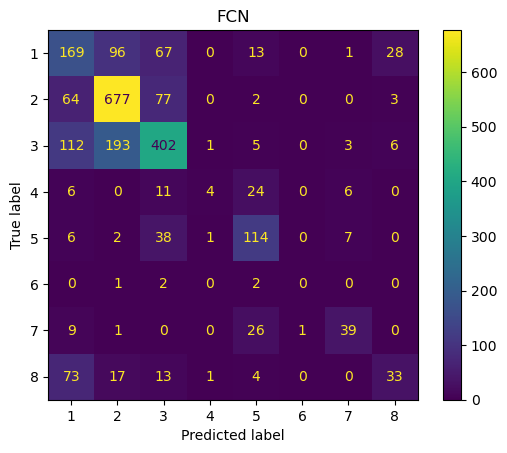

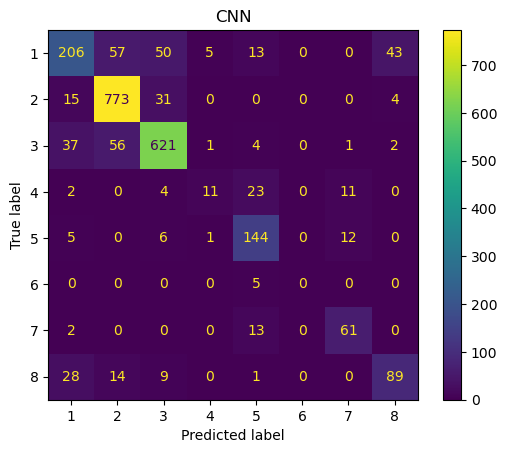

In [163]:
y_pred_fcn, y_true = plot_confusion_matrix(fcn, test_main_dl, "FCN")
y_pred_cnn, y_true = plot_confusion_matrix(cnn, test_main_dl, "CNN")

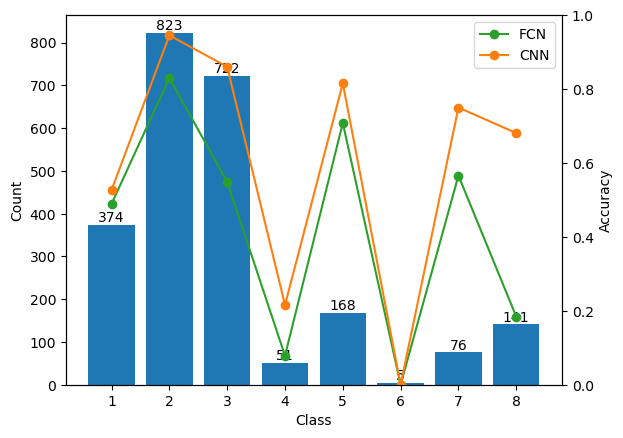

In [144]:
# analyze unbalancedness of the dataset

freq, bins = np.histogram(y_true, bins=range(9))


fig, ax1 = plt.subplots()
ax1.bar(range(1,9), freq, width=0.8, align='center')
ax1.set_xticks(range(1,9))
for fr, x in zip(freq, range(1, 9)):
  plt.annotate("{}".format(int(fr)),xy = (x, fr), ha = 'center', va = 'bottom')


ax1.set_xlabel("Class")
ax1.set_ylabel("Count")



def accuracy_by_class(y_pred, y_true):
    accs = []
    for i in range(8):
        idx = np.where(np.array(y_true) == i)[0]
        accs.append((np.array(y_pred)[idx] == np.array(y_true)[idx]).sum() / len(idx))
    return accs

accs_fcn = accuracy_by_class(y_pred_fcn, y_true)
accs_cnn = accuracy_by_class(y_pred_cnn, y_true)
ax2 = ax1.twinx()
ax2.plot(range(1, 9), accs_fcn, 'o-', color="tab:green", label="FCN")
ax2.plot(range(1, 9), accs_cnn, 'o-', color="tab:orange",label="CNN")
ax2.set_ylim(0, 1)
ax2.set_ylabel("Accuracy")
ax2.legend(loc="upper right")

plt.show()

Class with much fewer data tend to be classified with lower accuracy by both models, eg. class 4 and 6. Note that the more training data does not necesserially lead to better accuracy, eg. comparing class 7 and 8. 

## Question 5: Transfer learning

In [152]:
# Re-use the frozen cnn_backbone from Q4 with a new classification head, training on the two unseen classes.

class CNN2(nn.Module):
    def __init__(self, device, backbone):
        super(CNN2, self).__init__()
        self.backbone = copy.deepcopy(backbone)
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.backbone.to(device)
        self.classifier = nn.Linear(64, 2).to(device)

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)
    

In [153]:
cnn2 = CNN2(device, cnn.cnn_backbone)

for epoch in range(20):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train(train_heldout_dl, cnn2, nn.CrossEntropyLoss(), torch.optim.Adam(cnn2.parameters(), lr=5e-3))
    test(test_heldout_dl, cnn2, nn.CrossEntropyLoss())

Epoch 1
-------------------------------


train loss 0.5825816: 100%|██████████| 16/16 [00:00<00:00, 87.94it/s]


Test Error: 
 Accuracy: 74.4%, Avg loss: 0.554792 

Epoch 2
-------------------------------


train loss 0.4739343: 100%|██████████| 16/16 [00:00<00:00, 108.11it/s]


Test Error: 
 Accuracy: 75.8%, Avg loss: 0.528228 

Epoch 3
-------------------------------


train loss 0.5915797: 100%|██████████| 16/16 [00:00<00:00, 90.51it/s]


Test Error: 
 Accuracy: 77.9%, Avg loss: 0.471842 

Epoch 4
-------------------------------


train loss 0.3318658: 100%|██████████| 16/16 [00:00<00:00, 107.60it/s]


Test Error: 
 Accuracy: 77.4%, Avg loss: 0.498138 

Epoch 5
-------------------------------


train loss 0.4138004: 100%|██████████| 16/16 [00:00<00:00, 108.02it/s]


Test Error: 
 Accuracy: 76.2%, Avg loss: 0.505057 

Epoch 6
-------------------------------


train loss 0.5705786: 100%|██████████| 16/16 [00:00<00:00, 106.75it/s]


Test Error: 
 Accuracy: 77.4%, Avg loss: 0.524727 

Epoch 7
-------------------------------


train loss 0.6417421: 100%|██████████| 16/16 [00:00<00:00, 106.87it/s]


Test Error: 
 Accuracy: 78.1%, Avg loss: 0.484097 

Epoch 8
-------------------------------


train loss 0.4932298: 100%|██████████| 16/16 [00:00<00:00, 107.94it/s]


Test Error: 
 Accuracy: 78.4%, Avg loss: 0.495188 

Epoch 9
-------------------------------


train loss 0.5737129: 100%|██████████| 16/16 [00:00<00:00, 108.07it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.503150 

Epoch 10
-------------------------------


train loss 0.4537591: 100%|██████████| 16/16 [00:00<00:00, 95.78it/s] 


Test Error: 
 Accuracy: 78.1%, Avg loss: 0.506712 

Epoch 11
-------------------------------


train loss 0.3820414: 100%|██████████| 16/16 [00:00<00:00, 70.83it/s]


Test Error: 
 Accuracy: 75.1%, Avg loss: 0.527990 

Epoch 12
-------------------------------


train loss 0.5804921: 100%|██████████| 16/16 [00:00<00:00, 94.61it/s] 


Test Error: 
 Accuracy: 76.2%, Avg loss: 0.512590 

Epoch 13
-------------------------------


train loss 0.5285922: 100%|██████████| 16/16 [00:00<00:00, 107.43it/s]


Test Error: 
 Accuracy: 77.4%, Avg loss: 0.508188 

Epoch 14
-------------------------------


train loss 0.4671384: 100%|██████████| 16/16 [00:00<00:00, 107.54it/s]


Test Error: 
 Accuracy: 78.4%, Avg loss: 0.512061 

Epoch 15
-------------------------------


train loss 0.5356623: 100%|██████████| 16/16 [00:00<00:00, 108.31it/s]


Test Error: 
 Accuracy: 76.5%, Avg loss: 0.517029 

Epoch 16
-------------------------------


train loss 0.5625439: 100%|██████████| 16/16 [00:00<00:00, 92.03it/s] 


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.497745 

Epoch 17
-------------------------------


train loss 0.5378784: 100%|██████████| 16/16 [00:00<00:00, 67.78it/s]


Test Error: 
 Accuracy: 78.4%, Avg loss: 0.484607 

Epoch 18
-------------------------------


train loss 0.4694351: 100%|██████████| 16/16 [00:00<00:00, 105.00it/s]


Test Error: 
 Accuracy: 76.5%, Avg loss: 0.521605 

Epoch 19
-------------------------------


train loss 0.3637460: 100%|██████████| 16/16 [00:00<00:00, 101.51it/s]


Test Error: 
 Accuracy: 75.5%, Avg loss: 0.515497 

Epoch 20
-------------------------------


train loss 0.5096592: 100%|██████████| 16/16 [00:00<00:00, 104.14it/s]


Test Error: 
 Accuracy: 76.7%, Avg loss: 0.501627 



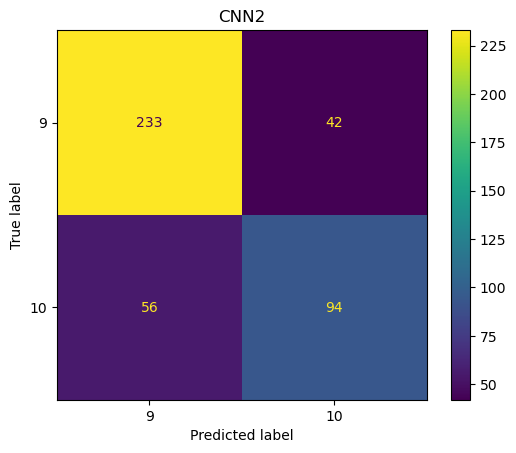

CNN2 accuracy: 0.7694117647058824


In [188]:
y_pred_cnn2, y_true_heldout = plot_confusion_matrix(cnn2, test_heldout_dl, "CNN2", labels=[9, 10])
acc_cnn2 = (np.array(y_pred_cnn2) == np.array(y_true_heldout)).sum() / len(y_true_heldout)
print(f"CNN2 accuracy: {acc_cnn2}")